## Portolio I: Sentiment Analysis

The main focus will discover model evaluation of different machine learning model. For this I use the data of yealp reviews of Hamburg.

In [138]:
import pandas as pd
from transformers import pipeline
import torch
import torch.nn.functional as F
from langdetect import detect
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [99]:
yelp_reviews = pd.read_csv("data/yelp_reviews_hamburg_en.csv")
yelp_reviews.head()

,url,stars,text,date
0,https://www.yelp.com/biz/il-buco-hamburg,5.0,Fantastic little restaurant!Great staff and fo...,2017-08-12
1,https://www.yelp.com/biz/campus-suite-hamburg-7,4.0,We went there to grab some breakfast. They are...,2015-09-29
2,https://www.yelp.com/biz/campus-suite-hamburg-7,4.0,"Good coffee, sandwiches, and yogurts close t...",2016-01-13
3,https://www.yelp.com/biz/campus-suite-hamburg-7,3.0,When XING handed out coupons for free coffee d...,2008-04-24
4,https://www.yelp.com/biz/campus-suite-hamburg-7,4.0,I love Campus Suite franchise. after the Balza...,2010-01-15


In [100]:
yelp_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025 entries, 0 to 3024
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   url     3025 non-null   object 
 1   stars   3025 non-null   float64
 2   text    3025 non-null   object 
 3   date    3025 non-null   object 
dtypes: float64(1), object(3)
memory usage: 94.7+ KB


In [101]:
yelp_reviews.describe()

,stars
count,3025.000000
mean,4.076033
std,1.094798
min,1.000000
25%,4.000000
50%,4.000000
75%,5.000000
max,5.000000


In [102]:
yelp_reviews.shape

(3025, 4)

The last step in preprocessing is to check whether there are duplicates or missing values in the data set.<br> The result is that the dataset has no duplicates and no nan values.

In [103]:
# Checking duplicates rows
duplicateRows = yelp_reviews[yelp_reviews.duplicated()]
# CHecking na values
na_values = yelp_reviews.isnull().sum().sum()
print(
    f"The dataset has {duplicateRows.shape[0]} duplicates and has {na_values} nan values."
)

The dataset has 0 duplicates and has 0 nan values.


## Data Exploration
In the data analysis we want to get a picture of how the data is distributed. The ratings and texts are to be examined.

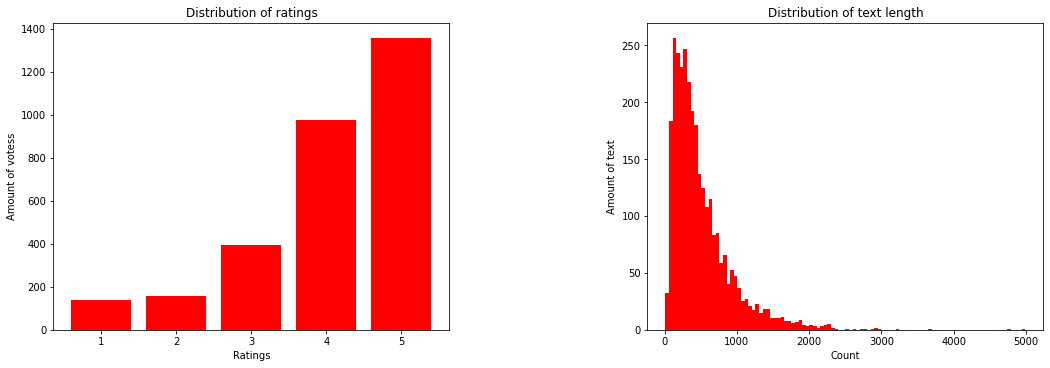

In [104]:
yelp_reviews_ratings = yelp_reviews.groupby("stars").agg("count").reset_index()
fig, ax = plt.subplots(1, 2)
plt.subplots_adjust(left=None, bottom=None, right=1.5, top=0.9, wspace=0.5, hspace=None)
ax[0].bar(yelp_reviews_ratings.stars, yelp_reviews_ratings.url, color="r")
# Bar Plot
ax[0].set_ylabel("Amount of votess")
ax[0].set_xlabel("Ratings")
ax[0].set_title("Distribution of ratings")
# 2. Plot
yelp_reviews["amount_text"] = yelp_reviews["text"].apply(
    lambda x: sum(word in x for word in x)
)

ax[1].hist(yelp_reviews["amount_text"], bins=100, color="r")
# Bar Plot
ax[1].set_ylabel("Amount of text")
ax[1].set_xlabel("Count")
ax[1].set_title("Distribution of text length")
# Save figure
# plt.savefig("output/time_product_buy", bbox_inches="tight")
# Show Plot

plt.show()

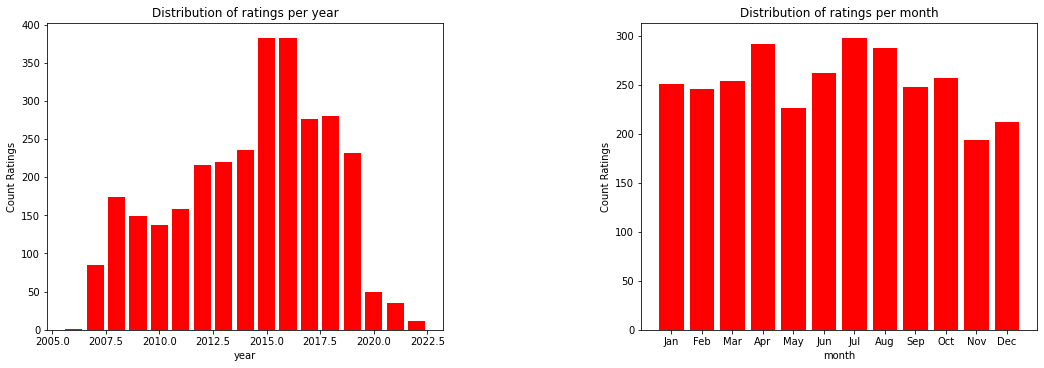

In [105]:
# Get extra Features out of the InvoiceDate
yelp_reviews["date"] = pd.to_datetime(yelp_reviews["date"])
yelp_reviews["year"] = yelp_reviews["date"].dt.year
yelp_reviews["month"] = yelp_reviews["date"].dt.strftime("%b")
yelp_reviews["weekday"] = yelp_reviews["date"].dt.strftime("%a")
year = yelp_reviews.groupby("year", as_index=False).agg(Count_stars=("stars", "count"))
fig, ax = plt.subplots(1, 2)
plt.subplots_adjust(left=None, bottom=None, right=1.5, top=0.9, wspace=0.5, hspace=None)
ax[0].bar(year["year"], year["Count_stars"], color="r")
# Bar Plot
ax[0].set_ylabel("Count Ratings")
ax[0].set_xlabel("year")
ax[0].set_title("Distribution of ratings per year")
# 2. Plot
month = yelp_reviews.groupby(
    [yelp_reviews["date"].dt.strftime("%m"), "month"], as_index=False
).agg(Count_stars=("stars", "count"))
ax[1].bar(month["month"], month["Count_stars"], color="r")
# Bar Plot
ax[1].set_ylabel("Count Ratings")
ax[1].set_xlabel("month")
ax[1].set_title("Distribution of ratings per month")
# Save figure
# plt.savefig("output/time_product_buy", bbox_inches="tight")
# Show Plot
plt.show()

## Pre-Processing
At the preprocessing we want to get grid of useless data and want to check our data and bring oit also in a better form for our models. <br>
The first step is to check the language. As a starting point, the data set from yelp was taken, which contains English restaurant reviews. To achieve better results in our ratings, it is important that the language is the same. It turns out that 85 comments are not written in English. Most of the 85 comments are in English. In the further course, it will be shown which other languages are also present in the comments.

In [106]:
yelp_reviews["language"] = yelp_reviews["text"].apply(lambda x: detect(x))
yelp_reviews[yelp_reviews["language"] != "en"].head()

,url,stars,text,date,amount_text,year,month,weekday,language
44,https://www.yelp.com/biz/cafe-strauss-hamburg,5.0,Wir waren erneut zum Frühstück unter der Woche...,2013-08-27,167,2013,Aug,Tue,de
65,https://www.yelp.com/biz/kumpir-hamburg-6,5.0,Gaaaanz lecker und preiswert!!!! Ich stimme zu...,2011-08-24,161,2011,Aug,Wed,de
66,https://www.yelp.com/biz/kumpir-hamburg-6,5.0,Absoluter Fan. Standard bei mir Habibi mit Hüh...,2013-03-03,134,2013,Mar,Sun,de
70,https://www.yelp.com/biz/kumpir-hamburg-6,5.0,"Für preiswerte 3,70EUR gibt es hier eine Mahlz...",2011-12-03,549,2011,Dec,Sat,de
96,https://www.yelp.com/biz/chakra-caf%C3%A9-hamb...,4.0,"ruehrei war lecker, orientalisches Fruehstueck...",2012-11-08,80,2012,Nov,Thu,de


The evaluation of the languages shows that the data set also includes other languages such as German, French, danish, dutch, norweign or Spanish.

In [107]:
yelp_reviews[yelp_reviews["language"] != "en"]["language"].value_counts()

de    76
fr     3
nl     1
lt     1
da     1
es     1
Name: language, dtype: int64

Our later models can only make good predictions of sentiment for one language, so we need to remove non-English comments.

In [108]:
yelp_reviews_en = yelp_reviews[yelp_reviews["language"] == "en"]

In [140]:
evaluation_df = pd.DataFrame(
    {
        "model": [],
        "accuracy": [],
        "confusion matrix": [],
    }
)

## Transformer Model
The first model is to be created on the basis of a transformer. For this purpose, a model from Huggingface is used, which was trained on the basis of ratings and determines sentiments from 1-5. First, it will be investigated how well a model performs without FineTuning. The model is based on Bert and is multilingual. It supports the languages English, German, Dutch, French, Italian and Spanish. The developers state an accuracy of 67% for the English language. In this model, I would like to compare how the comments from English only differ from the mixed data set.

In [54]:
sentiment_pipeline = pipeline(
    "sentiment-analysis", "nlptown/bert-base-multilingual-uncased-sentiment"
)

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

The Config can be used to obtain information about the model. The Bert model has 5 labels as output and a BertForSequenceClassification architecture. The output is a string that evaluates the rating based on "1 star" -> 1.

In [81]:
print(sentiment_pipeline.model.config)

BertConfig {
  "_name_or_path": "nlptown/bert-base-multilingual-uncased-sentiment",
  "_num_labels": 5,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "finetuning_task": "sentiment-analysis",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "1 star",
    "1": "2 stars",
    "2": "3 stars",
    "3": "4 stars",
    "4": "5 stars"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "1 star": 0,
    "2 stars": 1,
    "3 stars": 2,
    "4 stars": 3,
    "5 stars": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_to

To get a better overview of the Tokenizer, you can display the Tokenizer. You will notice that the model may have a maximum of 512 characters as input. This means that the data we can use for the experiment is significantly smaller.

In [82]:
sentiment_pipeline.tokenizer

PreTrainedTokenizerFast(name_or_path='nlptown/bert-base-multilingual-uncased-sentiment', vocab_size=105879, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

After adjusting the maximum length of comments to 512 characters, the data set has dropped to 1929. Compared to the initial data set, we can only use 60% of the data.

In [113]:
yelp_reviews = yelp_reviews[yelp_reviews["amount_text"] <= 512]
print(f"The dataset contains now {yelp_reviews.shape[0]} samples.")
yelp_reviews_en = yelp_reviews_en[yelp_reviews_en["amount_text"] <= 512]
print(f"The english dataset contains now {yelp_reviews_en.shape[0]} samples.")

The dataset contains now 1929 samples.
The english dataset contains now 1863 samples.


In [128]:
yelp_reviews["rating"] = yelp_reviews["text"].apply(
    lambda x: sentiment_pipeline(x)[0].get("label")
)
yelp_reviews["rating"] = yelp_reviews["rating"].apply(lambda x: int(x[0]))
yelp_reviews = yelp_reviews.astype({"stars": int})

In [141]:
acc_score = accuracy_score(yelp_reviews["stars"], yelp_reviews["rating"])
cm = confusion_matrix(
    yelp_reviews["stars"], yelp_reviews["rating"], labels=[1, 2, 3, 4, 5]
)
evaluation_df = evaluation_df.append(
    pd.DataFrame(
        {"model": ["Transformer"], "accuracy": [acc_score], "confusion matrix": [cm]}
    )
)

C:\Users\wuest\AppData\Local\Temp\ipykernel_17312\2319997950.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_df = evaluation_df.append(pd.DataFrame({"model":["Transformer"],"accuracy":[acc_score],"confusion matrix":[cm]}))


In [139]:
yelp_reviews_en["rating"] = yelp_reviews_en["text"].apply(
    lambda x: sentiment_pipeline(x)[0].get("label")
)
yelp_reviews_en["rating"] = yelp_reviews_en["rating"].apply(lambda x: int(x[0]))
yelp_reviews_en = yelp_reviews_en.astype({"stars": int})

In [142]:
acc_score = accuracy_score(yelp_reviews_en["stars"], yelp_reviews_en["rating"])
cm = confusion_matrix(
    yelp_reviews_en["stars"], yelp_reviews_en["rating"], labels=[1, 2, 3, 4, 5]
)
evaluation_df = evaluation_df.append(
    pd.DataFrame(
        {"model": ["Transformer EN"], "accuracy": [acc_score], "confusion matrix": [cm]}
    )
)

C:\Users\wuest\AppData\Local\Temp\ipykernel_17312\437593630.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_df = evaluation_df.append(pd.DataFrame({"model":["Transformer EN"],"accuracy":[acc_score],"confusion matrix":[cm]}))


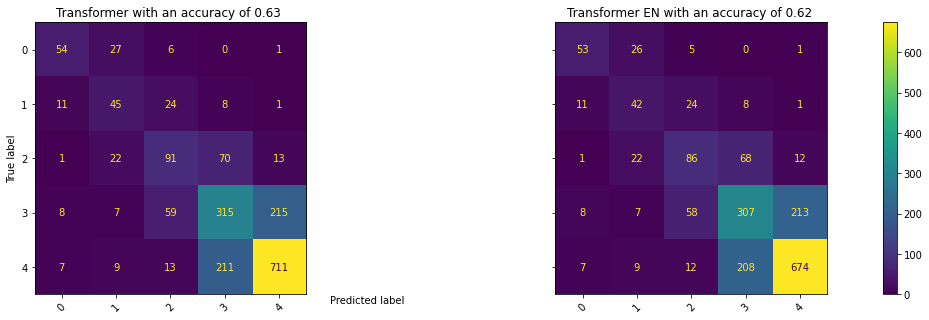

In [143]:
f, axes = plt.subplots(1, 2, figsize=(20, 5), sharey="row")

for i in range(2):
    disp = ConfusionMatrixDisplay(confusion_matrix=evaluation_df.iloc[i, 2])
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(
        f"{evaluation_df.iloc[i,0]} with an accuracy of {round(evaluation_df.iloc[i,1],2)} "
    )
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel("")
    if i != 0:
        disp.ax_.set_ylabel("")

f.text(0.4, 0.1, "Predicted label", ha="left")
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

In [144]:
evaluation_df

,model,accuracy,confusion matrix
0,Transformer,0.630378,"[[54, 27, 6, 0, 1], [11, 45, 24, 8, 1], [1, 22..."
0,Transformer EN,0.623725,"[[53, 26, 5, 0, 1], [11, 42, 24, 8, 1], [1, 22..."


## Pre-trained Model with Hugging Face

In [146]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    BertTokenizerFast as BertTokenizer,
    BertModel,
    AdamW,
    get_linear_schedule_with_warmup,
)

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
HAPPY_COLORS_PALETTE = [
    "#01BEFE",
    "#FFDD00",
    "#FF7D00",
    "#FF006D",
    "#ADFF02",
    "#8F00FF",
]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams["figure.figsize"] = 12, 8

pl.seed_everything(RANDOM_SEED)

c:\Users\wuest\Documents\Master_FH_Kiel\2.Semester\Social_media_analytics\Socia-Media-Analytics\.venv\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\wuest\Documents\Master_FH_Kiel\2.Semester\Social_media_analytics\Socia-Media-Analytics\.venv\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 42


42

In [167]:
yelp_reviews.head()

,url,text,date,amount_text,year,month,weekday,language,rating,stars_1,stars_2,stars_3,stars_4,stars_5
0,https://www.yelp.com/biz/il-buco-hamburg,Fantastic little restaurant!Great staff and fo...,2017-08-12,412,2017,Aug,Sat,en,5,0,0,0,0,1
2,https://www.yelp.com/biz/campus-suite-hamburg-7,"Good coffee, sandwiches, and yogurts close t...",2016-01-13,121,2016,Jan,Wed,en,4,0,0,0,1,0
4,https://www.yelp.com/biz/campus-suite-hamburg-7,I love Campus Suite franchise. after the Balza...,2010-01-15,225,2010,Jan,Fri,en,5,0,0,0,1,0
6,https://www.yelp.com/biz/m%C3%A9lange-hamburg,The best chicken sandwich I've ever had was fr...,2018-03-20,230,2018,Mar,Tue,en,5,0,0,0,0,1
7,https://www.yelp.com/biz/m%C3%A9lange-hamburg,Easily the best chicken sandwich I've ever had...,2017-04-26,369,2017,Apr,Wed,en,5,0,0,0,0,1


Create Train, Val and test data

In [150]:
yelp_reviews = pd.get_dummies(yelp_reviews, prefix=["stars"], columns=["stars"])

KeyError: "None of [Index(['stars'], dtype='object')] are in the [columns]"

In [151]:
train_df, val_df = train_test_split(yelp_reviews, test_size=0.2)
train_df.shape, val_df.shape

((1543, 14), (386, 14))

In [163]:
BERT_MODEL_NAME = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
LABEL_COLUMNS = yelp_reviews.columns.tolist()[9:]
MAX_TOKEN_COUNT = 512

In [164]:
LABEL_COLUMNS

['stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5']

In [45]:
sample_row = yelp_reviews.iloc[16]
sample_comment = sample_row.text
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment)
print()
print(sample_labels.to_dict())

I had some of the best Calamari here that I have ever had.  The cocktails looked big and good. (A friend with me had a few of those).  I had two very large servings of that Bitte Hefe weissen which I really enjoyed.  The service was friendly and good.  They have a big board with the menu on it in German.  They will tell you what it is in English though if your German is not that good like mine. :)

{'stars_1.0': 0, 'stars_2.0': 0, 'stars_3.0': 0, 'stars_4.0': 1, 'stars_5.0': 0}


In [174]:
from helper.dataloader import DataSetCreator, RatedCommentDataModule, RatedCommentTagger

In [175]:
train_dataset = DataSetCreator(
    train_df, LABEL_COLUMNS, tokenizer, max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [166]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [176]:
N_EPOCHS = 10
BATCH_SIZE = 12

data_module = RatedCommentDataModule(
    train_df, val_df, tokenizer, batch_size=BATCH_SIZE, max_token_len=MAX_TOKEN_COUNT
)

In [177]:
data_module.setup()

In [178]:
data_module.train_dataloader()

c:\Users\wuest\Documents\Master_FH_Kiel\2.Semester\Social_media_analytics\Socia-Media-Analytics\.venv\lib\site-packages\torch\utils\data\dataloader.py:487: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [179]:
dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
    optimizer.step()
    scheduler.step()
    learning_rate_history.append(optimizer.param_groups[0]["lr"])

c:\Users\wuest\Documents\Master_FH_Kiel\2.Semester\Social_media_analytics\Socia-Media-Analytics\.venv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


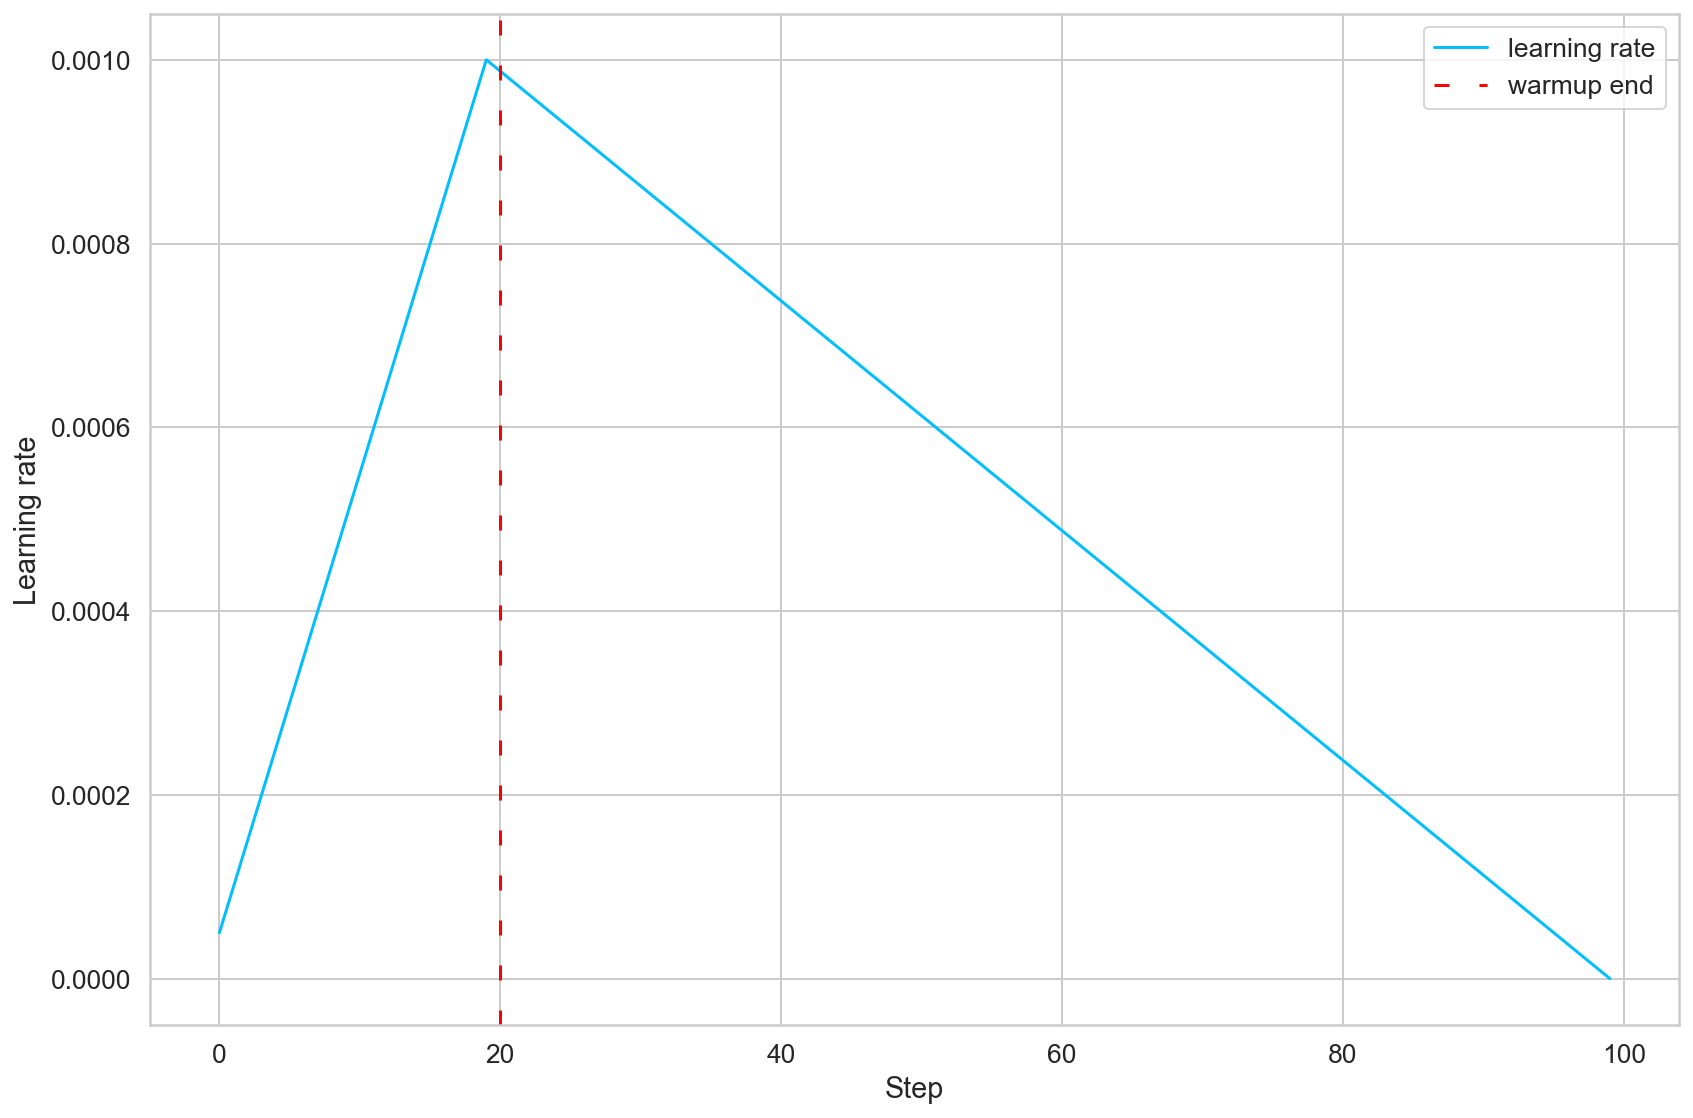

In [180]:
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

In [181]:
steps_per_epoch = len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [182]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(256, 1280)

In [184]:
model = RatedCommentTagger(
    bert_model=BERT_MODEL_NAME,
    n_classes=len(LABEL_COLUMNS),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps,
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [185]:
criterion = nn.BCELoss()

prediction = torch.FloatTensor(
    [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)
labels = torch.FloatTensor([1.0, 0.0, 0.0, 0.0, 1.0, 0.0])

## Training

In [2]:
!rm -rf lightning_logs/
!rm -rf checkpoints/

In [1]:
%load_ext tensorboard
%tensorboard --logir ./lightning_logs

In [186]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min",
)

In [187]:
logger = TensorBoardLogger("lightning_logs", name="toxic-comments")

In [188]:
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=2)

In [189]:
trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    callbacks=[early_stopping_callback],
    max_epochs=N_EPOCHS,
    progress_bar_refresh_rate=1,
)

c:\Users\wuest\Documents\Master_FH_Kiel\2.Semester\Social_media_analytics\Socia-Media-Analytics\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:151: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x000002263C4F0940>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x000002263C4F0940>)`.
  rank_zero_deprecation(
c:\Users\wuest\Documents\Master_FH_Kiel\2.Semester\Social_media_analytics\Socia-Media-Analytics\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks

In [190]:
TOKENIZERS_PARALLELISM = False

In [192]:
trainer.fit(model, data_module)


  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 3.8 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.256   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\wuest\Documents\Master_FH_Kiel\2.Semester\Social_media_analytics\Socia-Media-Analytics\.venv\lib\site-packages\torch\utils\data\_utils\worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "c:\Users\wuest\Documents\Master_FH_Kiel\2.Semester\Social_media_analytics\Socia-Media-Analytics\.venv\lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "c:\Users\wuest\Documents\Master_FH_Kiel\2.Semester\Social_media_analytics\Socia-Media-Analytics\.venv\lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "c:\Users\wuest\Documents\Master_FH_Kiel\2.Semester\Social_media_analytics\Socia-Media-Analytics\sentiment_analysis\helper\dataloader.py", line 66, in __getitem__
    labels = data_row[self.columns]
  File "c:\Users\wuest\Documents\Master_FH_Kiel\2.Semester\Social_media_analytics\Socia-Media-Analytics\.venv\lib\site-packages\pandas\core\series.py", line 945, in __getitem__
    key = com.apply_if_callable(key, self)
  File "c:\Users\wuest\Documents\Master_FH_Kiel\2.Semester\Social_media_analytics\Socia-Media-Analytics\.venv\lib\site-packages\pandas\core\common.py", line 358, in apply_if_callable
    return maybe_callable(obj, **kwargs)
  File "c:\Users\wuest\Documents\Master_FH_Kiel\2.Semester\Social_media_analytics\Socia-Media-Analytics\.venv\lib\site-packages\transformers\tokenization_utils_base.py", line 2451, in __call__
    raise ValueError(
ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).


## Pre Trained Huggingface

In [200]:
yelp_reviews = pd.read_csv("data/yelp_reviews_hamburg_en.csv")
yelp_reviews = yelp_reviews.astype({"stars": int})
yelp_reviews["stars"] = yelp_reviews["stars"].apply(lambda x: x - 1)

In [201]:
yelp_reviews.head()

,url,stars,text,date
0,https://www.yelp.com/biz/il-buco-hamburg,4,Fantastic little restaurant!Great staff and fo...,2017-08-12
1,https://www.yelp.com/biz/campus-suite-hamburg-7,3,We went there to grab some breakfast. They are...,2015-09-29
2,https://www.yelp.com/biz/campus-suite-hamburg-7,3,"Good coffee, sandwiches, and yogurts close t...",2016-01-13
3,https://www.yelp.com/biz/campus-suite-hamburg-7,2,When XING handed out coupons for free coffee d...,2008-04-24
4,https://www.yelp.com/biz/campus-suite-hamburg-7,3,I love Campus Suite franchise. after the Balza...,2010-01-15


In [202]:
train_df, val_df = train_test_split(yelp_reviews, test_size=0.2)

In [203]:
train_df = train_df[["stars", "text"]]

In [204]:
val_df = val_df[["stars", "text"]]

In [205]:
val_df.to_csv("data/test.csv", index=False)

In [206]:
train_df.to_csv("data/train.csv", index=False)

In [208]:
train_df = train_df[["stars", "text"]]
train_df = train_df.to_dict("records")

TypeError: list indices must be integers or slices, not list

In [210]:
val_df = val_df[["stars", "text"]]
val_df = val_df.to_dict("records")

In [212]:
from datasets import load_dataset

In [213]:
dataset = load_dataset(
    "csv", data_files={"train": "data/train.csv", "test": "data/test.csv"}
)

Using custom data configuration default-13afbf9adb78d160


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to C:\Users\wuest\.cache\huggingface\datasets\csv\default-13afbf9adb78d160\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [214]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "nlptown/bert-base-multilingual-uncased-sentiment"
)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [215]:
tokenized_datasets = tokenized_datasets.rename_column("stars", "labels")
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")

In [216]:
tokenized_datasets.set_format("torch")

In [217]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42)

In [218]:
small_train_dataset = small_train_dataset.remove_columns(["text"])
small_eval_dataset = small_eval_dataset.remove_columns(["text"])

ValueError: Column name text not in the dataset. Current columns in the dataset: ['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [219]:
small_train_dataset

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2420
})

In [220]:
small_train_dataset = small_train_dataset.remove_columns(["token_type_ids"])
small_eval_dataset = small_eval_dataset.remove_columns(["token_type_ids"])

In [221]:
small_train_dataset["input_ids"].size(), small_eval_dataset["input_ids"].size()

(torch.Size([2420, 512]), torch.Size([605, 512]))

In [222]:
small_train_dataset

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 2420
})

In [223]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "nlptown/bert-base-multilingual-uncased-sentiment"
)

In [240]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./sentiment-analysis",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    save_strategy="epoch",
    evaluation_strategy="steps",
)

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [234]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

In [233]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [241]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [242]:
trainer.train()

***** Running training *****
  Num examples = 2420
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 303


  0%|          | 0/303 [00:00<?, ?it/s]

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 100663296 bytes.

In [80]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=5)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=5)

In [81]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased", num_labels=5
)

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /Users/tom.wuesten/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers

In [82]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [83]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [84]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [89]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        print(batch)
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/1452 [00:00<?, ?it/s]

{'labels': tensor([4., 3., 4., 1., 3.]), 'input_ids': tensor([[  101,   157,  5123,  ...,     0,     0,     0],
        [  101,  6702,  1110,  ...,     0,     0,     0],
        [  101, 12004,  1363,  ...,     0,     0,     0],
        [  101,  1188,  4382,  ...,     0,     0,     0],
        [  101, 12974, 17925,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


ValueError: Target size (torch.Size([5])) must be the same as input size (torch.Size([5, 5]))